In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(8,6)})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!cp drive/My\ Drive/yapaitek/exported_csv_montreal_tv_locals_after_imputing_missing_data.csv .
!cp drive/My\ Drive/yapaitek/test.csv .

1. "Temperature in Montreal during episode" column was imputed by "Multiple Imputations by Chained Equations(MICE) method because more than 5% of data was missing (about 13 percent), but this feature never used because it does not have any correlation with the independent value



2. There were 43 missing values in Start_time, End_time which are now removed



3. Dataset columns are renamed and formatted 

In [31]:
raw_data = pd.read_csv('exported_csv_montreal_tv_locals_after_imputing_missing_data.csv',index_col=['Id'])
raw_data['Year'] = raw_data['Year'].astype('category')
raw_data.sort_values(['Id']).head(3)

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Genre,First time or rerun,Number of episode in the season,Movie,Game of the Canadiens during episode,Temperature in Montreal during episode,Market Share_total
Id,,,,,,,,,,,,,,,,,,
0,VidÃ©oclips V,V Total,General Channel,Fall,2016,2016-08-29 00:00:00.000,Monday,2016-08-29 06:00:00.000,2016-08-29 08:00:00.000,8,VidÃ©oclips V,Music Video Clips,No,Yes,No,No,20.400,0.9
1,Apollo dans l'frigo,V Total,General Channel,Fall,2016,2016-08-29 00:00:00.000,Monday,2016-08-29 08:00:00.000,2016-08-29 08:30:00.000,2,Apollo dans l'frigo,Informal Education and Recreation and Leisure,No,Yes,No,No,19.125,0.5
2,InfopublicitÃ©,V Total,General Channel,Fall,2016,2016-08-29 00:00:00.000,Monday,2016-08-29 08:30:00.000,2016-08-29 09:00:00.000,2,InfopublicitÃ©,"Infomercials, Promotional and Corporate Videos",No,Yes,No,No,19.125,0.3


In [0]:
import datetime as dt

raw_data["quarter"] = pd.to_datetime(raw_data['Date']).dt.quarter
raw_data['quarter'] = raw_data['quarter'].astype('category')

In [33]:
raw_data.describe(include='all')

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Genre,First time or rerun,Number of episode in the season,Movie,Game of the Canadiens during episode,Temperature in Montreal during episode,Market Share_total,quarter
count,616613,616613,616613,616613,616613.0,616613,616613,616613,616613,616613.000000,616613,616613,616613,616613,616613,616613,616613.000000,616613.000000,616613.0
unique,6551,24,2,4,4.0,877,7,138321,138333,NaN,6551,27,2,2,2,2,NaN,NaN,4.0
top,ComplÃ©ment de programme canadien,Teletoon Fr.+,Specialty Channel,Fall,2018.0,2018-02-07 00:00:00.000,Wednesday,2018-02-18 02:00:00.000,2018-09-21 23:00:00.000,NaN,ComplÃ©ment de programme canadien,Animated Television Programs & Films,No,Yes,No,No,NaN,NaN,4.0
freq,9413,50746,535913,234291,260111.0,840,89726,27,32,NaN,9413,88876,599428,605960,610326,568803,NaN,NaN,192577.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.203927,NaN,NaN,NaN,NaN,NaN,NaN,6.707849,3.011577,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.306816,NaN,NaN,NaN,NaN,NaN,NaN,11.326101,4.919651,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-27.425000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.325000,0.400000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.671228,1.400000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,15.575000,3.400000,NaN


### Correlation between temperature and market share

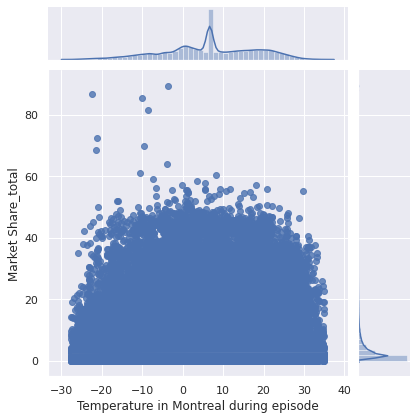

In [34]:
sns.jointplot(x = raw_data['Temperature in Montreal during episode'], y = raw_data['Market Share_total'],kind="reg")

### No missing values!

In [35]:
raw_data.isna().sum()

Episode                                   0
Station                                   0
Channel Type                              0
Season                                    0
Year                                      0
Date                                      0
Day of week                               0
Start_time                                0
End_time                                  0
Length                                    0
Name of show                              0
Genre                                     0
First time or rerun                       0
Number of episode in the season           0
Movie                                     0
Game of the Canadiens during episode      0
Temperature in Montreal during episode    0
Market Share_total                        0
quarter                                   0
dtype: int64

### Exploring the PDFs 

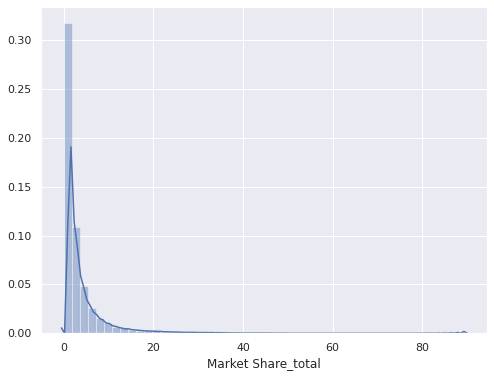

In [36]:
sns.distplot(raw_data['Market Share_total'])

### No outlier detection this time:)

In [37]:
raw_data['Length'] = raw_data['Length'].astype('category')
data_cleaned = raw_data.reset_index(drop=True)
data_cleaned.head()

,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Genre,First time or rerun,Number of episode in the season,Movie,Game of the Canadiens during episode,Temperature in Montreal during episode,Market Share_total,quarter
0,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-27 00:00:00.000,Monday,2018-08-27 05:30:00.000,2018-08-27 06:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,20.125,0.0,3
1,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-27 00:00:00.000,Monday,2018-08-27 06:30:00.000,2018-08-27 07:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,19.925,0.0,3
2,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-28 00:00:00.000,Tuesday,2018-08-28 05:30:00.000,2018-08-28 06:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,21.925,0.0,3
3,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-28 00:00:00.000,Tuesday,2018-08-28 06:00:00.000,2018-08-28 06:30:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,21.525,0.0,3
4,Coup de foudre,"MusiquePlus+ (retired Aug 25, 2019)",Specialty Channel,Fall,2018,2018-08-29 00:00:00.000,Wednesday,2018-08-29 05:30:00.000,2018-08-29 06:00:00.000,2,Coup de foudre,General Entertainment and Human Interest,No,Yes,No,No,22.925,0.0,3


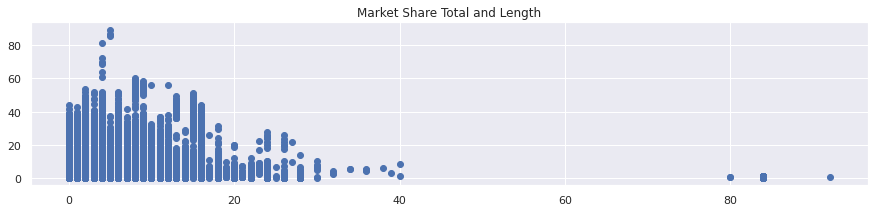

In [38]:
f, (ax1) = plt.subplots(1,1, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned["Length"], data_cleaned["Market Share_total"])
ax1.set_title("Market Share Total and Length")
# ax2.scatter(data_cleaned["Temperature in Montreal during episode"], data_cleaned["Market Share_total"])
# ax2.set_title("Market Share Total and Temperature")
plt.show()

### Label Encoder

In [0]:
from sklearn import preprocessing

final_data = data_cleaned[["Station","Year","Length","Market Share_total","Genre","quarter","Day of week"]]
cols = ["Station","Year","Length","Genre","quarter","Day of week"]
le = preprocessing.LabelEncoder()

for col in cols:
  le.fit(final_data[col])
  final_data[col + '_encoded'] = le.transform(final_data[col]) 

In [0]:
final_data_encoded = final_data[["Station_encoded","Year_encoded","Length_encoded","Market Share_total","Genre_encoded","quarter_encoded","Day of week_encoded"]]

### Standardization and train_test Split

In [0]:
target = final_data_encoded["Market Share_total"]
inputs = final_data_encoded.drop(["Market Share_total"],axis=1)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.1, random_state=21)


###  Machine Learning Models

In [0]:
#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate

#Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LassoCV, LassoLarsCV,ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

RandomForestRegressor: 0.758483 (+/- 0.001743)
GradientBoostingRegressor: 0.667027 (+/- 0.003931)
DecisionTreeRegressor: 0.750185 (+/- 0.002760)


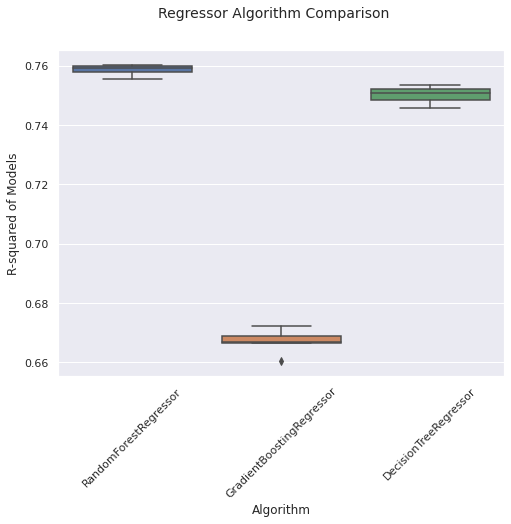

In [44]:
### empty list
clfs = []

clfs.append(("RandomForestRegressor",
             Pipeline([("Scaler", RobustScaler()),
                       ("RandomForestRegressor", RandomForestRegressor())]))) 
clfs.append(("GradientBoostingRegressor",
             Pipeline([("Scaler", RobustScaler()),
                       ("GradientBoosting", GradientBoostingRegressor())]))) 

clfs.append(("DecisionTreeRegressor",
             Pipeline([("Scaler", RobustScaler()),
                       ("DART", DecisionTreeRegressor())]))) 

### Metrics
#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 5

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds)
    cv_results = cross_val_score(model, x_train, y_train, cv= kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(8,6))
fig.suptitle('Regressor Algorithm Comparison', fontsize=14)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=12)
ax.set_ylabel("R-squared of Models", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

### Stacking multiple models

In [0]:
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import xgboost as xgb

Dart = make_pipeline(RobustScaler(), DecisionTreeRegressor())

RForest = make_pipeline(RobustScaler(), RandomForestRegressor())


model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [51]:
from sklearn.metrics import r2_score
#Validation function
n_folds = 5

# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
#     rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

stacked_averaged_models = StackingAveragedModels(base_models = (model_xgb, RForest),
                                                 meta_model = model_lgb)
# score = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


stacked_averaged_models.fit(x_train.values, y_train.values)


StackingAveragedModels(base_models=(XGBRegressor(base_score=0.5,
                                                 booster='gbtree',
                                                 colsample_bylevel=1,
                                                 colsample_bynode=1,
                                                 colsample_bytree=0.4603,
                                                 gamma=0.0468,
                                                 importance_type='gain',
                                                 learning_rate=0.05,
                                                 max_delta_step=0, max_depth=3,
                                                 min_child_weight=1.7817,
                                                 missing=None,
                                                 n_estimators=2200, n_jobs=1,
                                                 nthread=-1,
                                                 objective='reg:linear',
                     

In [52]:
stacked_train_pred = stacked_averaged_models.predict(x_train.values)
stacked_test_pred = stacked_averaged_models.predict(x_test.values)
print(r2_score(y_train.values, stacked_train_pred))
print(r2_score(y_test.values, stacked_test_pred))

0.7547662157409504
0.7394610578572207


In [57]:
test_df = pd.read_csv("test.csv")
test_df_original = test_df.copy()
test_df.describe(include="all")

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Temperature in Montreal during episode
count,154165.000000,154165,154165,154165,154165,154165.0,154165,154165,154143,154143,154165.000000,154165,123546,154165,154165,154165,154165,154165,130936.000000
unique,NaN,2760,22,2,3,NaN,216,7,37328,37358,NaN,2760,36776,27,2,2,2,2,NaN
top,NaN,Buzz,Teletoon Fr.+,Specialty Channel,Winter,NaN,2019-02-06,Wednesday,2019-08-21 02:00:00,2019-04-14 02:00:00,NaN,Buzz,(P),Animated Television Programs & Films,No,Yes,No,No,NaN
freq,NaN,3375,14767,132271,69287,NaN,750,22598,25,27,NaN,3375,3005,25170,150843,150078,152444,148061,NaN
mean,77083.000000,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,3.124834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.597632
std,44503.746462,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,5.323143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.642658
min,1.000000,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.775000
25%,38542.000000,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.325000
50%,77083.000000,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.150000
75%,115624.000000,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.250000


In [58]:
test_df.isna().sum()

Unnamed: 0                                    0
Episode                                       0
Station                                       0
Channel Type                                  0
Season                                        0
Year                                          0
Date                                          0
Day of week                                   0
Start_time                                   22
End_time                                     22
Length                                        0
Name of show                                  0
Name of episode                           30619
Genre                                         0
First time or rerun                           0
# of episode in the season                    0
Movie?                                        0
Game of the Canadiens during episode?         0
Temperature in Montreal during episode    23229
dtype: int64

In [0]:
test_df["Start_time"].fillna(inplace=True,value=0)
test_df["End_time"].fillna(inplace=True,value=0)

In [0]:
test_df['Year'] = test_df['Year'].astype('category')
test_df["quarter"] = pd.to_datetime(test_df['Date']).dt.quarter
test_df['quarter'] = test_df['quarter'].astype('category')
test_df['Length'] = test_df['Length'].astype('category')

In [0]:
test_final = test_df[["Station","Year","Length","Genre","quarter","Day of week"]]
cols = test_final.columns
le = preprocessing.LabelEncoder()

for col in cols:
  le.fit(test_final[col])
  test_final[col + '_encoded'] = le.transform(test_final[col]) 

In [0]:
test_final_encoded = test_final[["Station_encoded","Year_encoded","Length_encoded","Genre_encoded","quarter_encoded","Day of week_encoded"]]
test_pred_final = stacked_averaged_models.predict(test_final_encoded.values)


In [0]:
test_df_original["Market Share_total"] =  test_pred_final

In [0]:
test_df_original.to_csv("Final_prediction.csv",index=False)

In [66]:
test_df_original.describe()

,Unnamed: 0,Year,Length,Temperature in Montreal during episode,Market Share_total
count,154165.000000,154165.0,154165.000000,130936.000000,154165.000000
mean,77083.000000,2019.0,3.124834,8.597632,3.573744
std,44503.746462,0.0,5.323143,12.642658,4.826998
min,1.000000,2019.0,0.000000,-22.775000,0.096806
25%,38542.000000,2019.0,2.000000,-1.325000,0.844728
50%,77083.000000,2019.0,2.000000,10.150000,1.874736
75%,115624.000000,2019.0,4.000000,19.250000,3.611687
max,154165.000000,2019.0,92.000000,32.075000,25.931410
